<a href="http://landlab.github.io"><img style="float: left" src="../../landlab_header.png"></a>

## How to read a DEM as a Landlab grid

This tutorial demonstrates how to create and initialize a Landlab grid using a Digital Elevation Model (DEM). The DEM is in ESRI's Ascii Grid format. The procedure both creates a new grid, and adds a field to the grid containing the DEM data. Note that there are other approaches to construct a Landlab grid, including the use of the `gdal` library to read a DEM into a numpy array, followed by  initializing a Landlab RasterModelGrid of the correct size and then adding the array as a grid field. This tutorial, however, describes an approach that uses the Landlab `read_esri_ascii` function.

The starting point is to obtain a DEM in Ascii Grid format, or
convert it to this format. The format consists of a 6-line header
followed by a series of elevation values. Here we'll work with a
small example DEM file called *west_bijou_gully.asc*. The header
for this file is as follows:

```
ncols        43
nrows        89
xllcorner    559705.000000000000
yllcorner    4380220.000000000000
cellsize     3
NODATA_value 0
```

Here, our objective is to translate the contents of this file into a Landlab RasterModelGrid. We'll do this using the ``read_esri_ascii`` function. Here's how to use it:

In [1]:
from landlab.io import read_esri_ascii

In the line above, we go to Landlab's input/output library ("io") and import the function. Next, let's look at the basic documentation:

In [2]:
# read_esri_ascii?

Ok, this tells us we need to supply the name of the file. If we want the data as a 2D array, we also specify ``reshape = True`` (normally this isn't necessary, as Landlab stores fields as flat arrays). If we want to attach the elevation data to the grid as a field, we also give a name for the field as the ``name`` parameter. For example:

In [3]:
(mg, z) = read_esri_ascii("west_bijou_gully.asc", name="topographic__elevation")

Let's plot the grid we created:

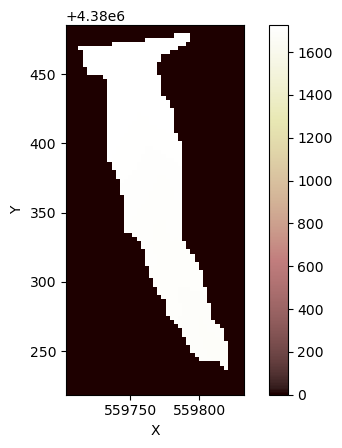

In [4]:
mg.imshow("topographic__elevation")

This plot illustrates the shape of the watershed, but we can't see the topography because the nodata values have a value of zero, which skews the colormap.  We can change the range of the colormap but first we need to figure out what the range of data values are. 

(Note: uncomment the commented line below if you want to see all the options available in ``imshow``)

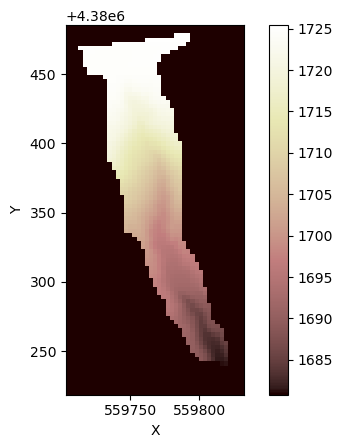

In [5]:
import numpy as np

min_z = np.min(z[np.where(z > 0)])
max_z = np.max(z[np.where(z > 0)])
# help(mg.imshow)
mg.imshow("topographic__elevation", limits=(min_z, max_z))

We can also query a bit of information:

In [6]:
mg.number_of_node_rows

89

In [7]:
mg.number_of_node_columns

43

## Boundary condition handling

### The rest of this tutorial illustrates setting boundary conditions on DEMs and using the halo option for reading in DEMs without nodata values around the edges.

Because this is a watershed, we probably want to set *watershed boundary conditions.*  For more on setting watershed boundary conditions on rasters, see [this tutorial](../boundary_conds/set_watershed_BCs_raster.ipynb)

In essence, the `set_watershed_boundary_condition` function identifies the non-NODATA grid node with the lowest elevation. This node is assumed to be the watershed outlet. The boundary status of the outlet node is converted from "core" to "fixed value," meaning that it is now a boundary node. All NODATA nodes are flagged as "closed," and as a result all links that connect to them are flagged as "inactive." These codes can then be used by components and models to restrict certain numerical operations to a subset of grid elements; for example, one might calculate a topographic gradient only at active links, or update elevation values only on core nodes. (For more on boundary condition handling in general, see the tutorials in the boundary_conds folder.

We also replot the watershed, this time coloring by the node status, which illustrates the boundary condition at each node.

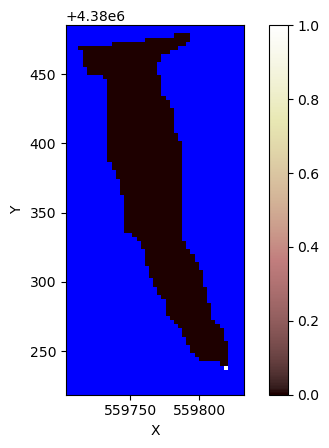

In [8]:
mg.set_watershed_boundary_condition(z, 0)
mg.imshow(mg.status_at_node, color_for_closed="blue")

All of the closed boundary nodes are shown in blue.  Without the `color_for_closed` option they would plot as the minimum value, or black.  A value of 0 node status means that the node is a core node, or operational, and a value of 1 means that the node is a fixed value boundary. The singular node with a value of 1 (white in the plot) is assumed to be the watershed outlet.

### Access DEM header

It is helpful to know the NODATA value and other values in the header.  Sure you could just open the file, but it might be huge.  Here is how to access those values.

In [9]:
from landlab.io import read_asc_header

fop = open("synthetic_landscape.asc", "r")
hdr = read_asc_header(fop)
hdr

{'ncols': 10,
 'nrows': 10,
 'xllcorner': 0.0,
 'yllcorner': 0.0,
 'cellsize': 5.0,
 'nodata_value': -9.0}

This illustrates that the nodata value for this particular DEM file is -9.

### Adding a halo

Next we illustrate reading in a DEM that is not a watershed, and use of the halo option.

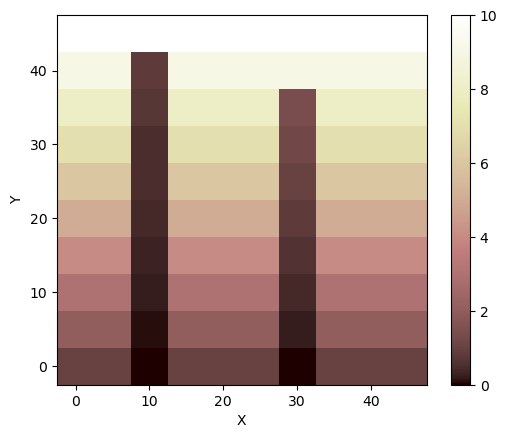

In [10]:
(mg1, z1) = read_esri_ascii("synthetic_landscape.asc", name="topographic__elevation")
mg1.imshow(z1)

This landscape has data values at all of its points.  (Recall that the nodata_value is -9, but all of the values plotted here are >= 0.)

If we set an open boundary on the bottom or south side, and the rest of the boundaries as closed, as illustrated below, some of our data values will become closed boundaries, and operations will not be carried out at these nodes.  This is illustrated in the map of boundary status values, which has the three blue sides indicating that the boundaries along these sides are closed.

Note that the default is that the perimeter will have fixed value node status, or a value of 1.

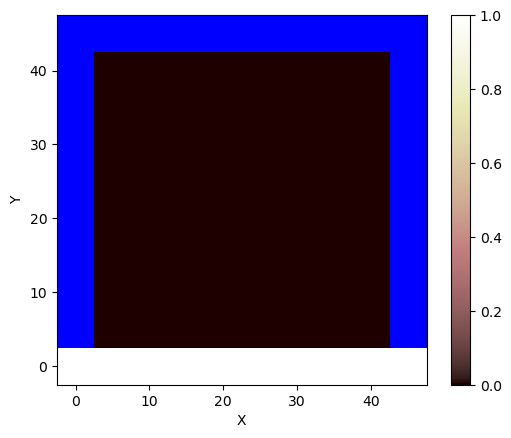

In [11]:
mg1.set_closed_boundaries_at_grid_edges(True, True, True, False)
mg1.imshow(mg1.status_at_node, color_for_closed="blue")

The implication of this map is that the right, top and left edges are closed now, and therefore these node values will not be operated on (assuming that the author of the component or model has written their program to restrict certain calculations to core nodes only). Similarly, the bottom row is fixed value, so it also won't be operated on.

Supposed we want to include some or all of these DEM grid points in model operations.  We need to set them as core nodes, but we can't have core nodes on the perimeter of a grid.  One solution is to add a "halo" of extra nodes around the grid's perimeter.  The halo option adds a perimeter of nodes around the data that are read in from the esri_ascii file.  This is helpful when there are valid data values at the edges of a grid.  By default, the elevation values associated with halo perimeter nodes will be assigned the DEM's NODATA code value (for example, -9999 is a common choice for a NODATA code).

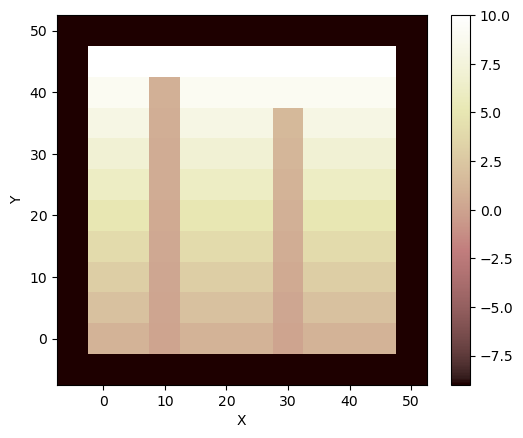

In [12]:
(mg2, z2) = read_esri_ascii(
    "synthetic_landscape.asc", name="topographic__elevation", halo=1
)
mg2.imshow(z2)

### Now setting the boundary conditions ... 

In this case, we will set all of the edges as closed.  We will set the bottom of the two channels (points x=15, y=5 and x=35, y=5) as fixed-value boundaries.  One could also set all of the data values in the second row from the bottom as fixed value.  Appropriate boundary conditions obviously depend on the environmental conditions that one is modeling.

Note there are multiple ways to do this.  I happen to know that the node id of the two channel bottoms are 15 and 19.  So we will set those as fixed value individually.  We will also illustrate another useful boundary condition function, which sets all nodata values to closed. 

In [ ]:
mg2.set_nodata_nodes_to_closed(z2, -9.0)

mg2.status_at_node[15] = mg2.BC_NODE_IS_FIXED_VALUE
mg2.status_at_node[19] = mg2.BC_NODE_IS_FIXED_VALUE
mg2.imshow(mg2.status_at_node, color_for_closed="blue")

There are lots of ways we could have done this.  In a more complicated DEM we would probably want to search for the smallest z values in the second row in order to figure out which should be fixed values.  For more on setting raster boundary conditions see this [tutorial](../boundary_conds/set_BCs_on_raster_perimeter.ipynb)